In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/Computer Vision course/HGR-CNN pho bien/data_HGR.zip')
zip_ref.extractall()


In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Add
from keras.models import load_model, Input, Model
from tensorflow.keras.applications import *
import os
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

#load data


In [ ]:
train_path = '/content/TeachingAssigntant_HGR1/train'
test_path = '/content/TeachingAssigntant_HGR1/test'
val_path= '/content/TeachingAssigntant_HGR1/val'

Xem qua 1 số ảnh kết quả segment

In [ ]:
#thư mục_path = os.path.join(đường dẫn, tên thư mục trong path)
def show_image(dataset_path):
  image_list = []
  for folder in os.listdir(dataset_path): #lấy tên
    #print(os.path.join(dataset_path, folder))
    image_path = os.path.join(os.path.join(dataset_path, folder), os.listdir(os.path.join(dataset_path, folder))[0]) 
    #print(image_path)
    image_list.append([cv2.imread(image_path), folder]) #image(ảnh, tên ảnh)
  plt.subplots(figsize=(10,10))
  for i in range(14):
    plt.subplot(1, 14, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_list[i][0])
    plt.xlabel(image_list[i][1])
  plt.show()

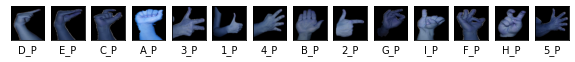

In [ ]:
show_image(train_path)

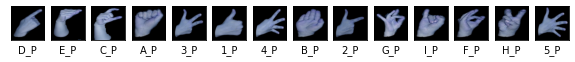

In [ ]:
show_image(test_path)

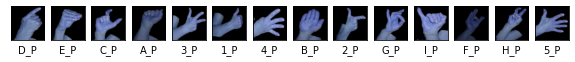

In [ ]:
show_image(val_path)

#Data augment

In [ ]:
#preprocessing_funtion = lambda x: x/255.0*2-1
train_datagen = ImageDataGenerator(
    rescale=1./255,
    vertical_flip=True, #lật theo chiều ngang
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    zoom_range=[0.7, 1.7],
)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_data = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode = 'categorical')
test_data = train_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, class_mode = 'categorical')
val_data = train_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, class_mode = 'categorical')

Found 407 images belonging to 14 classes.
Found 28 images belonging to 14 classes.
Found 27 images belonging to 14 classes.


#Resnet50

In [ ]:

from tensorflow.keras.applications import ResNet50
def ResNet50_HGR1(input_shape = (224, 224, 3)):
  input = Input(shape = input_shape)
  based_model = ResNet50(include_top=False, weights=None, input_tensor=input).output
  x = GlobalAveragePooling2D() (based_model)
  x = Dense(128, activation='relu', kernel_initializer = 'he_normal')(x)
  x = Dropout(0.3) (x)
  output = Dense(14, activation='softmax', kernel_initializer='he_normal') (x)
  model = Model(inputs = input, outputs = output)
  #model = Model(inputs = [input1, input2], outputs = [output1, output2])
  model.summary()
  return model

In [ ]:
resnet50 = ResNet50_HGR1()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
resnet50.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
resnet50.save('model_restnet50.h5')


In [ ]:
my_callback = [ReduceLROnPlateau(min_lr=0.00001), ModelCheckpoint(filepath='resnet_{epoch:}_{val_accuracy:}.hdf5', monitor='val_accuracy', save_best_only=True)]

In [ ]:
#resnet50 = load_model('restnet_470_0.48148149251937866.hdf5')
##resnet50.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
#my_callback = [ReduceLROnPlateau(min_lr=0.00001), ModelCheckpoint('/content/gdrive/My Drive/Computer Vision course/HGR-CNN pho bien/resnet/resnet_{epoch:}_{val_accuracy:}.hdf5', monitor='val_accuracy', save_best_only=True)]

In [ ]:
steps_per_epoch=407//32+1
validation_step = 27//32+1
history = resnet50.fit(train_data, batch_size=32, validation_batch_size=32, epochs = 930, validation_data=val_data, steps_per_epoch=steps_per_epoch, validation_steps = validation_step, callbacks=my_callback, initial_epoch=470)

Epoch 471/930
13/13 [==============================] - 343s 26s/step - loss: 4.0685 - accuracy: 0.0688 - val_loss: 2.7245 - val_accuracy: 0.0741 - lr: 0.0010
Epoch 472/930
13/13 [==============================] - 322s 25s/step - loss: 2.7930 - accuracy: 0.0860 - val_loss: 2.6405 - val_accuracy: 0.0741 - lr: 0.0010
Epoch 473/930
13/13 [==============================] - 323s 25s/step - loss: 2.6576 - accuracy: 0.0762 - val_loss: 2.6449 - val_accuracy: 0.0741 - lr: 0.0010
Epoch 474/930
13/13 [==============================] - 323s 25s/step - loss: 2.6437 - accuracy: 0.0762 - val_loss: 2.6374 - val_accuracy: 0.0741 - lr: 0.0010
Epoch 475/930
13/13 [==============================] - 323s 25s/step - loss: 2.6390 - accuracy: 0.0713 - val_loss: 2.6380 - val_accuracy: 0.0741 - lr: 0.0010
Epoch 476/930
13/13 [==============================] - 321s 25s/step - loss: 2.6389 - accuracy: 0.0663 - val_loss: 2.6380 - val_accuracy: 0.0741 - lr: 0.0010
Epoch 477/930
13/13 [==============================]

KeyboardInterrupt: ignored

#Transfer Learning (chuyển giao tri thức)

1. Lý do cần áp dụng *Transfer Learning* trong bài này
- Bộ dữ liệu rất nhỏ chỉ với 454 ảnh gồm 14 class, mỗi class 31 ảnh
- tập train: 407 ảnh, val: 27 ảnh
- Mô hình (Resnet50) sẽ khó học được các đặc trưng tổng quát cho việc phân loại các cử chỉ tay. Từ đó, khi test độ chính xác trên những bộ dữ liệu mới độ chính xác sẽ bị giảm.
- Đặc biệt, mô hình Resnet50 rất phức tạp. Với bộ dữ liệu lớn thì ko sao. Tuy nhiên, bộ dữ liệu của chúng ta rất nhỏ, tốc độ chính xác bị giảm, overfit dễ xảy ra.
2. *Transfer Learning* trong bài này
- 4 tình huống gặp khi sử dụng Transfer Learning:
  + Bài toán mới của mình dùng có bộ dữ liệu lớn giống bộ dữ liệu mình pretrain model: Trường hợp tốt nhất
  + Gặp bộ dữ liệu mới lớn và khác bộ dữ liệu mình dùng pretrained: thường thì ngta sẽ huấn luyện lại từ đầu
  + Bộ dữ liệu nhỏ và giống bộ dữ liệu mk pretrained: thường sử dụng cho trường hợp này chỉ cần bỏ các lớp FC ở cuối model.
  + Bộ dữ liệu nhỏ và khác bộ dữ liệu của mk: ngoài việc mà mk loại bỏ các lớp FC ở cuối thì cũng có thể loại bỏ các lớp mà trích xuất ra các đặc trưng high level.
- Như chúng ra biết thì bộ dữ liệu ImageNet là một bộ dữ liệu lớn với 1000 class khác nhau. Vậy chúng ta sẽ sử dụng mạng pretrained Resnet50 với weights của ImageNet trong bài này
- Trong TH bài này, chúng ta sẽ dùng Transfer Learning trong trường hợp small dataset, different data. Nên ngoài bỏ các FC Layers, chúng ta sẽ bỏ thêm 1 số layers có đặc điểm nhận dạng các đặc điểm phưc tạp cao.
3. Các bước của Transfer Learning
- Đóng băng các lớp based model
- Sau 1 khoảng time mà thấy cái model hội tụ với data mới rồi thì một fine tuning.


#đóng băng các lớp trong based model

In [ ]:
base = ResNet50(include_top=False, weights = 'imagenet', input_shape = (224, 224, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
base.trainanle = False #đóng băng

#input = Input(shape=(224, 224, 3))
x = base.output

x = GlobalAveragePooling2D() (x)

x = BatchNormalization() (x)
x = Dropout(0.3) (x)

x = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (x)
x = BatchNormalization() (x)
x = Dropout(0.5) (x)

output = Dense(14, activation = 'softmax', kernel_initializer='he_normal') (x)
transfer = Model(inputs = base.input, outputs = output)
transfer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
transfer.save('model_transfer.h5')

In [ ]:
transfer.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), metrics='accuracy')
my_callback = [ReduceLROnPlateau(monitor='val_loss', patience=20, verbose=1, factor= 0.1, min_lr=0.00000001), 
               ModelCheckpoint(filepath='resnet_freez1_{epoch:}_{val_accuracy:}.hdf5', monitor='val_accuracy', save_best_only=True)]

In [ ]:
history = transfer.fit(train_data, batch_size=32, validation_batch_size=32, epochs=900, validation_data=val_data, steps_per_epoch=407//32+1, validation_steps=27//32+1, callbacks=my_callback)

Epoch 1/900
13/13 [==============================] - 354s 27s/step - loss: 3.2804 - accuracy: 0.1622 - val_loss: 798.0135 - val_accuracy: 0.0741 - lr: 0.0010
Epoch 2/900
13/13 [==============================] - 302s 23s/step - loss: 2.9883 - accuracy: 0.1941 - val_loss: 3531.9436 - val_accuracy: 0.0741 - lr: 0.0010
Epoch 3/900
13/13 [==============================] - 299s 23s/step - loss: 2.6280 - accuracy: 0.2138 - val_loss: 132.9952 - val_accuracy: 0.0741 - lr: 0.0010
Epoch 4/900
13/13 [==============================] - 294s 23s/step - loss: 2.4183 - accuracy: 0.3120 - val_loss: 13.4467 - val_accuracy: 0.0741 - lr: 0.0010
Epoch 5/900
13/13 [==============================] - 291s 22s/step - loss: 2.1413 - accuracy: 0.3489 - val_loss: 2.8291 - val_accuracy: 0.0741 - lr: 0.0010
Epoch 6/900
 4/13 [========>.....................] - ETA: 3:21 - loss: 1.8019 - accuracy: 0.3828

KeyboardInterrupt: ignored

#Gỡ đóng băng của các lớp base (fine Tuning)

1. Fine Tuning
- Đây là 1 bước không bắt buộc trong transfer Learning
- Được thực hiện khi mà model bạn đã hội tụ trên bộ dữ liệu mới. Chúng ta có thể dựa vào kết quả của val_los và val_acc để xác định xem liệu mô hình đã hội tụ trên dữ liệu mới chưa
- Bước này có thể dẫn đến overfitting.
2. Cách thức thực hiện
- Trước hêt chuyển thuộc tính trainable = True và chuyển min_lr = 0.000001

In [ ]:
#batchNormalization --> variance và mean
for layer in transfer.layers:
  string = layer.name.split('_')
  if 'bn' not in string:
    layer.trainable=True

In [ ]:
transfer.summary()

In [ ]:
transfer.save('model_transfer_fineTuning.h5')

In [ ]:
transfer.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), metrics='accuracy')
my_callback = [ReduceLROnPlateau(monitor='val_loss', patience=20, verbose=1, factor= 0.1, min_lr=0.00000001), 
               ModelCheckpoint(filepath='resnet_fineTuning1_{epoch:}_{val_accuracy:}.hdf5', monitor='val_accuracy', save_best_only=True)]

history = transfer.fit(train_data, batch_size=32, validation_batch_size=32, epochs=900, validation_data=val_data, steps_per_epoch=407//32+1, validation_steps=27//32+1, callbacks=my_callback)

In [ ]:
transfer.evaluate(test_data)

#Một hướng tiếp cận khác trong Transfer Learning

- Đầu tiên, chúng ta sẽ làm như cách đầu cứ gội một cái base (Resnet50) và load trực tiếp weights của ImageNet vài nó.
- Tiếp đó, mk sẽ cho data mới mk qua base rồi record output của một hay nhiều lớp của base sau đó đưa trực tiếp qua cái model nhỏ hơn

In [ ]:
'''
img_size = (224, 224)
input_s = img_size+(3,)
print(input_s)'''

'\nimg_size = (224, 224)\ninput_s = img_size+(3,)\nprint(input_s)'

In [ ]:
def Resnet_alterflow(img_size=(224, 224, 3)):
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size)
  x = base_model.output
  x = GlobalAveragePooling2D() (x)
  x = BatchNormalization() (x)
  x = Dropout(0.3) (x)

  x = Dense(128, activation='relu', kernel_initializer='he_normal') (x)
  x = BatchNormalization() (x)
  x = Dropout(0.5) (x)

  output = Dense(14, activation = 'softmax', kernel_initializer='he_normal') (x)
  model = Model(inputs=base_model.input, outputs = output)
  model.summary()

  return model

In [ ]:
transfer = Resnet_alterflow()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
transfer.save('model_transfer_FineTuning2.h5')

In [ ]:
from keras import callbacks
transfer.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics='accuracy')
my_callback = [ReduceLROnPlateau(min_lr=0.00000001), ModelCheckpoint('resnet_finetuning2_{{epoch:}_{val_accuracy:}.hdf5', monitor='val_accuracy', save_best_only=True)]

In [ ]:
steps_per_epoch = 407//32 + 1
validation_step = 27//32 + 1
history = transfer.fit(train_data, batch_size=32, validation_batch_size=32, epochs = 900, validation_data=val_data, steps_per_epoch=steps_per_epoch, validation_steps=validation_step, callbacks=my_callback)

Epoch 1/900
13/13 [==============================] - ETA: 0s - loss: 3.4754 - accuracy: 0.1622 

ValueError: ignored